In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
# get the total os classes
# specify the CSV file path
csv_file_path = "model/keypoint_classifier/keypoint_classifier_label.csv"


with open(csv_file_path, "r") as file: # open the CSV file in read mode
    line_count = 0
    for line in file:
        line_count += 1

classes_names = line_count + 1

In [4]:
# number os classes are the total in classes file
NUM_CLASSES = 9

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 [=========>....................] - ETA: 1s - loss: 2.3608 - accuracy: 0.0703
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 1s 97ms/step - loss: 2.3068 - accuracy: 0.0673 - val_loss: 2.2610 - val_accuracy: 0.1111
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 2.2493 - accuracy: 0.0938
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 23ms/step - loss: 2.2561 - accuracy: 0.0943 - val_loss: 2.2356 - val_accuracy: 0.1111
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 2.3053 - accuracy: 0.0391
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
3/3 [==============================] - 0s 25ms/step - loss: 2.2575 - accuracy: 0.0707 - val_loss: 2.2144 - val_accuracy: 0.1111
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 2.2297 - accuracy: 0.1094
Epoch 4: sav

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 23ms/step - loss: 0.1764 - accuracy: 0.9697


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]])) #type:ignore
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 77ms/step
[7.2299777e-10 3.7648815e-18 9.9831921e-01 1.6807913e-03 1.3430009e-15
 1.1126759e-11 2.4363425e-10 3.0800933e-08 6.2050171e-10]
2


# Confusion matrix

4/4 [==============================] - 0s 1ms/step


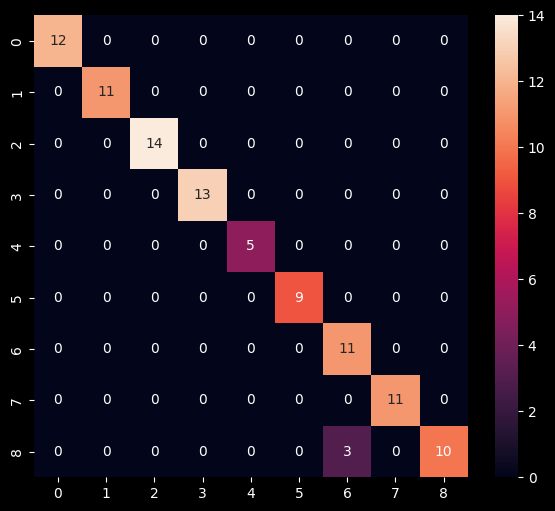

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         9
           6       0.79      1.00      0.88        11
           7       1.00      1.00      1.00        11
           8       1.00      0.77      0.87        13

    accuracy                           0.97        99
   macro avg       0.98      0.97      0.97        99
weighted avg       0.98      0.97      0.97        99



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.style.use('dark_background')

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test) #type: ignore
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False) #type: ignore

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #type: ignore
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\z003yt8j\AppData\Local\Temp\tmp7970brzq\assets


INFO:tensorflow:Assets written to: C:\Users\z003yt8j\AppData\Local\Temp\tmp7970brzq\assets


6764

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results)) #type: ignore
print(np.argmax(np.squeeze(tflite_results))) #type: ignore

[8.7739807e-08 3.2931425e-12 9.9998248e-01 1.6193828e-05 1.5543810e-12
 8.3894891e-11 1.1953587e-06 7.5318134e-08 7.2117186e-12]
2
